Importations initiales


In [1]:
def relever_coefficients(c, class_coeffs):
    p = []  # Vecteur p pour stocker les fractions de classes admises
    remaining_capacity = c  # Capacité restante du canal
    
    for coeff in class_coeffs:
        if remaining_capacity >= coeff:
            # Accepter toute la classe
            p.append(1)
            remaining_capacity -= coeff
        else:
            # Accepter seulement une fraction de la classe
            p.append(remaining_capacity / coeff)
            remaining_capacity = 0  # Plus de capacité après cette fraction
            break
    
    # Ajouter 0 pour les classes restantes (non admises)
    while len(p) < len(class_coeffs):
        p.append(0)
    
    # Alpha est la somme des coefficients admis
    alpha = sum(p)
    
    return p, alpha

# Exemple d'utilisation
c = 0.5
class_coeffs = [0.33, 0.08, 0.25, 0.34]  # Coefficients des classes

# Calculer le vecteur p et la valeur de alpha
p_vector, alpha_value = relever_coefficients(c, class_coeffs)
print(f"Vecteur p : {p_vector}")
print(f"Valeur de alpha : {alpha_value}")


Vecteur p : [1, 1, 0.35999999999999993, 0]
Valeur de alpha : 2.36


In [2]:
import numpy as np

class PacketAdmissionControl:
    def __init__(self, lambda_rate, class_rewards, class_probs, capacity_ratio, time_window):
        self.lambda_rate = lambda_rate  # Taux de processus Poisson (paquets par seconde)
        self.class_rewards = np.array(class_rewards)  # Récompenses pour chaque classe
        self.class_probs = np.array(class_probs)  # Probabilités pour chaque classe
        self.capacity = capacity_ratio * lambda_rate  # Capacité du canal
        self.time_window = time_window  # Fenêtre temporelle pour l'échantillonnage
        self.num_classes = len(class_rewards)  # Nombre de classes de jobs
    
    def generate_packet_class(self):
        # Simuler la classe à laquelle appartient un paquet en fonction des probabilités de classe
        return np.random.choice(self.num_classes, p=self.class_probs)
    
    def knapsack_optimal_policy(self):
        # Trier les classes par récompense décroissante
        sorted_indices = np.argsort(-self.class_rewards)
        sorted_rewards = self.class_rewards[sorted_indices]
        sorted_probs = self.class_probs[sorted_indices]
        
        # Initialisation
        total_capacity = self.capacity
        total_reward = 0.0
        optimal_policy = [0] * self.num_classes  # Initialiser avec "ne pas admettre" pour toutes les classes
        alpha = 0.0  # Somme des fractions des classes acceptées
        
        for i in range(self.num_classes):
            if sorted_probs[i] <= total_capacity:
                # Admettre la classe entière si la capacité est suffisante
                total_capacity -= sorted_probs[i]
                total_reward += sorted_rewards[i]
                optimal_policy[sorted_indices[i]] = 1  # Accepter
                alpha += 1  # Classe entièrement acceptée
            else:
                # Admettre une fraction de la classe si la capacité n'est pas suffisante
                fraction = total_capacity / sorted_probs[i]
                total_reward += sorted_rewards[i] * fraction
                optimal_policy[sorted_indices[i]] = fraction
                alpha += fraction  # Ajouter la fraction acceptée à alpha
                break  # Plus de capacité disponible
        
        return optimal_policy, total_reward, alpha

    def run_simulation(self):
        # Exécuter la simulation sur la fenêtre temporelle T et calculer la politique optimale
        arrivals = np.random.poisson(self.lambda_rate * self.time_window)
        admitted_packets = 0
        total_reward = 0.0
        alpha_total = 0.0

        for _ in range(arrivals):
            packet_class = self.generate_packet_class()
            packet_reward = self.class_rewards[packet_class]
            policy, reward, alpha = self.knapsack_optimal_policy()
            if policy[packet_class] > 0:
                admitted_packets += 1
                total_reward += packet_reward
            alpha_total = alpha  # Mettre à jour alpha à chaque exécution pour obtenir la valeur finale

        return admitted_packets, total_reward / admitted_packets if admitted_packets > 0 else 0, alpha_total

# Paramètres basés sur la Table 1
lambda_rate = 10**5  # Paquets par seconde (100 000 paquets par seconde)
class_rewards = [100, 50, 10, 1]  # Récompenses pour chaque classe
class_probs = [1/3, 1/12, 1/4, 1/3]  # Probabilités pour chaque classe
capacity_ratio = 0.5  # c = 1/2
time_window = 1  # Échantillonner toutes les 1 seconde

# Initialiser et exécuter la simulation
admission_control = PacketAdmissionControl(lambda_rate, class_rewards, class_probs, capacity_ratio, time_window)
admitted_packets, avg_reward, alpha = admission_control.run_simulation()

print(f"Admitted Packets: {admitted_packets}")
print(f"Average Reward: {avg_reward:.2f}")
print(f"Alpha (sum of accepted coefficients): {alpha:.2f}")


Admitted Packets: 100513
Average Reward: 40.32
Alpha (sum of accepted coefficients): 4.00


In [1]:
import numpy as np
import matplotlib.pyplot as plt


Variables globales et initialisation


In [23]:
# Paramètres du problème
N = 4  # Nombre de classes de jobs
r = np.array([100, 50, 10, 1])  # Récompenses des jobs
p = np.array([1/3, 1/12, 1/4, 1/3])  # Distribution des probabilités
λ = pow(10,5)  # Taux d'arrivée des paquets (packets par seconde)
c = 0.5 * λ  # Capacité du canal

# Simulation setup
np.random.seed(42)  # Pour la reproductibilité
T = 10000  # Temps total de simulation (secondes)
job_arrivals = np.random.poisson(λ, T)  # Arrivée de paquets selon un processus de Poisson


### Tâche 1: Politique stationnaire optimale (Knapsack Fractionnaire)
#### Le problème ici est d’admettre les paquets en fonction de la récompense et de la capacité du canal.



In [24]:
def optimal_threshold_policy(r, c, job_arrivals, p):
    # Trier les classes par récompense décroissante
    sorted_indices = np.argsort(-r)
    sorted_r = r[sorted_indices]
    sorted_p = p[sorted_indices]
    
    # Calculer le nombre de paquets arrivant par classe en utilisant le taux λ
    job_arrivals = λ * sorted_p  # Paquets par classe (proportionnel à p)

    # Implémentation du problème du sac à dos fractionnaire
    total_packets = 0
    admitted_reward = 0
    for i in range(N):
        if total_packets + job_arrivals[i] <= c:
            total_packets += job_arrivals[i]
            admitted_reward += job_arrivals[i] * sorted_r[i]
        else:
            # Admettre une partie de la dernière classe possible
            remaining_capacity = c - total_packets
            admitted_reward += remaining_capacity * sorted_r[i]
            break
            
    return admitted_reward

# Appliquer la politique optimale
optimal_reward = optimal_threshold_policy(r, c, job_arrivals, p)
print(f"Récompense optimale obtenue: {optimal_reward}")


Récompense optimale obtenue: 3833333.333333333


In [26]:
import numpy as np

# Paramètres du problème
lambda_packets = 10**5  # Taux d'arrivée des paquets (pkts/s)
c = 0.5 * lambda_packets  # Capacité du canal

# Paramètres des classes
N = 4  # Nombre de classes
r = np.array([100, 50, 10, 1])  # Récompenses pour chaque classe
p = np.array([1/3, 1/12, 1/4, 1/3])  # Probabilités pour chaque classe

# Calcul des arrivées pour chaque classe
arrival_rates = p * lambda_packets

# Résolution du problème de sac à dos fractionnaire
def solve_fractional_knapsack(arrival_rates, rewards, capacity):
    # Trier les classes par récompense décroissante
    sorted_indices = np.argsort(rewards)[::-1]
    sorted_arrival_rates = arrival_rates[sorted_indices]
    sorted_rewards = rewards[sorted_indices]
    
    admitted_rates = np.zeros_like(arrival_rates)
    total_admitted = 0.0
    
    # Admettre les paquets jusqu'à atteindre la capacité
    for i in range(len(sorted_arrival_rates)):
        if total_admitted + sorted_arrival_rates[i] <= capacity:
            admitted_rates[sorted_indices[i]] = sorted_arrival_rates[i]
            total_admitted += sorted_arrival_rates[i]
        else:
            # Admettre une fraction de la classe actuelle
            admitted_rates[sorted_indices[i]] = capacity - total_admitted
            break
    
    return admitted_rates

# Calcul des paquets admis
admitted_rates = solve_fractional_knapsack(arrival_rates, r, c)

# Affichage des résultats
print("Capacité du canal:", c)
print("Taux d'arrivée par classe:", arrival_rates)
print("Taux d'admission optimal par classe:", admitted_rates)
print("Répartition des classes admises:", admitted_rates / arrival_rates)




Capacité du canal: 50000.0
Taux d'arrivée par classe: [33333.33333333  8333.33333333 25000.         33333.33333333]
Taux d'admission optimal par classe: [33333.33333333  8333.33333333  8333.33333333     0.        ]
Répartition des classes admises: [1.         1.         0.33333333 0.        ]


Tâche 2: Algorithme de Robbins-Monro avec pas décroissant
Cet algorithme ajuste les probabilités d'admission avec un taux d’apprentissage qui décroît au fil des itérations pour équilibrer la vitesse de convergence avec la tolérance au bruit.



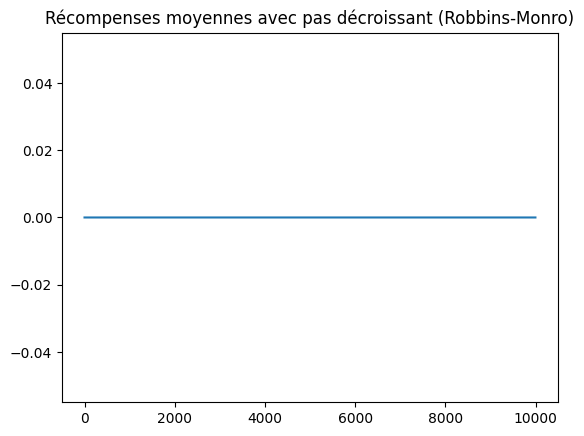

In [4]:
def robbins_monro_algorithm(r, c, job_arrivals, p, epsilon0, gamma):
    n = len(job_arrivals)
    theta = np.zeros(N)  # Paramètre initial pour chaque classe
    rewards = []
    
    for t in range(1, n):
        epsilon_t = epsilon0 / (t**gamma)
        job_class = np.random.choice(N, p=p)
        reward = r[job_class]
        
        if job_arrivals[t] <= c:
            theta[job_class] += epsilon_t * (reward - theta[job_class])
        
        rewards.append(np.sum(theta * p))  # Suivre la récompense moyenne
    
    return rewards

# Exécuter avec epsilon0 = 1.0 et gamma = 0.6
rewards_rm = robbins_monro_algorithm(r, c, job_arrivals, p, epsilon0=1.0, gamma=0.6)
plt.plot(rewards_rm)
plt.title("Récompenses moyennes avec pas décroissant (Robbins-Monro)")
plt.show()


#### Tâche 3: Algorithme avec pas constant
Ici, on maintient un pas constant pour l’algorithme, et on teste plusieurs valeurs pour ce pas.



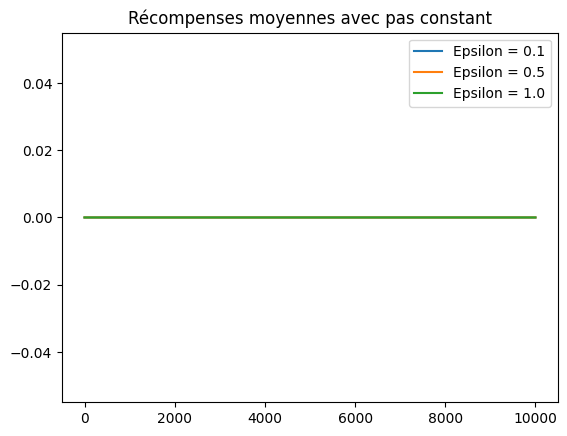

In [5]:
def constant_stepsize_algorithm(r, c, job_arrivals, p, epsilon):
    n = len(job_arrivals)
    theta = np.zeros(N)  # Paramètre initial
    rewards = []
    
    for t in range(n):
        job_class = np.random.choice(N, p=p)
        reward = r[job_class]
        
        if job_arrivals[t] <= c:
            theta[job_class] += epsilon * (reward - theta[job_class])
        
        rewards.append(np.sum(theta * p))  # Suivre la récompense moyenne
    
    return rewards

# Tester différentes valeurs de epsilon
epsilons = [0.1, 0.5, 1.0]
for epsilon in epsilons:
    rewards_const = constant_stepsize_algorithm(r, c, job_arrivals, p, epsilon)
    plt.plot(rewards_const, label=f"Epsilon = {epsilon}")

plt.title("Récompenses moyennes avec pas constant")
plt.legend()
plt.show()


Tâche 4: Moyennes de Polyak
Cette tâche consiste à utiliser les moyennes de Polyak pour stabiliser les résultats lorsque les pas sont décroissants.



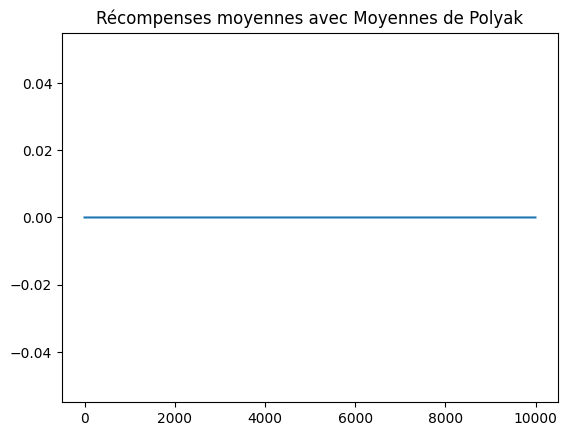

In [6]:
def polyak_averages(r, c, job_arrivals, p, epsilon0, gamma):
    n = len(job_arrivals)
    theta = np.zeros(N)
    avg_theta = np.zeros(N)
    rewards = []
    
    for t in range(1, n):
        epsilon_t = epsilon0 / (t**gamma)
        job_class = np.random.choice(N, p=p)
        reward = r[job_class]
        
        if job_arrivals[t] <= c:
            theta[job_class] += epsilon_t * (reward - theta[job_class])
        
        avg_theta += (theta - avg_theta) / t
        rewards.append(np.sum(avg_theta * p))  # Suivre la récompense moyenne
    
    return rewards

# Exécuter avec les moyennes de Polyak
rewards_polyak = polyak_averages(r, c, job_arrivals, p, epsilon0=1.0, gamma=0.6)
plt.plot(rewards_polyak)
plt.title("Récompenses moyennes avec Moyennes de Polyak")
plt.show()
